# Inicialización y preprocesamiento de datos

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from IPython.display import  HTML 
import math

sb.set()

In [35]:
all_data = np.load('dataset/proyecto_training_data.npy')
n_training_rows   = int(len(all_data) * 0.8)
training_data = all_data[:n_training_rows]
testing_data  = all_data[n_training_rows:]

print("loaded data")
print("training rows:  ", len(training_data))
print("testing  rows:  ", len(testing_data))
print("total data rows:", len(all_data))

loaded data
training rows:   1168
testing  rows:   292
total data rows: 1460


In [ ]:
# preprocessing
training_data[:,0] /= 1000 # expresar precio de venta en miles de dólares
training_data[:,2] /= 1000 # expresar pies cuadrados en el primer nivel en miles de pies^2


variables   = {}
for column, name in enumerate(('sale_price', 'quality', 'fst_fl_sqf', 'total_rooms', 'year_built', 'lot_front')):
    variables[name] = training_data[:,column]
    

# Análisis exploratorio de datos

### Resumen de variables

In [39]:
rows = []
for name, values in variables.items():
    mean  = np.nanmean(values)
    max_v = np.nanmax(values)
    min_v = np.nanmin(values)
    rng   = max_v - min_v
    std   = np.nanstd(values)
    rows.append({'avg': mean, 'min': min_v, 'max': max_v, 'range': rng, 'std': std})
    
df = pd.DataFrame(rows, index=variables.keys()).round(2)
HTML(df.to_html())

,avg,min,max,range,std
sale_price,180.59,34.90,755.00,720.10,78.78
quality,6.10,1.00,10.00,9.00,1.38
fst_fl_sqf,1.16,0.33,3.23,2.89,0.37
total_rooms,6.49,2.00,14.00,12.00,1.61
year_built,1971.45,1875.00,2010.00,135.00,29.94
lot_front,69.95,21.00,313.00,292.00,23.47


### Histogramas

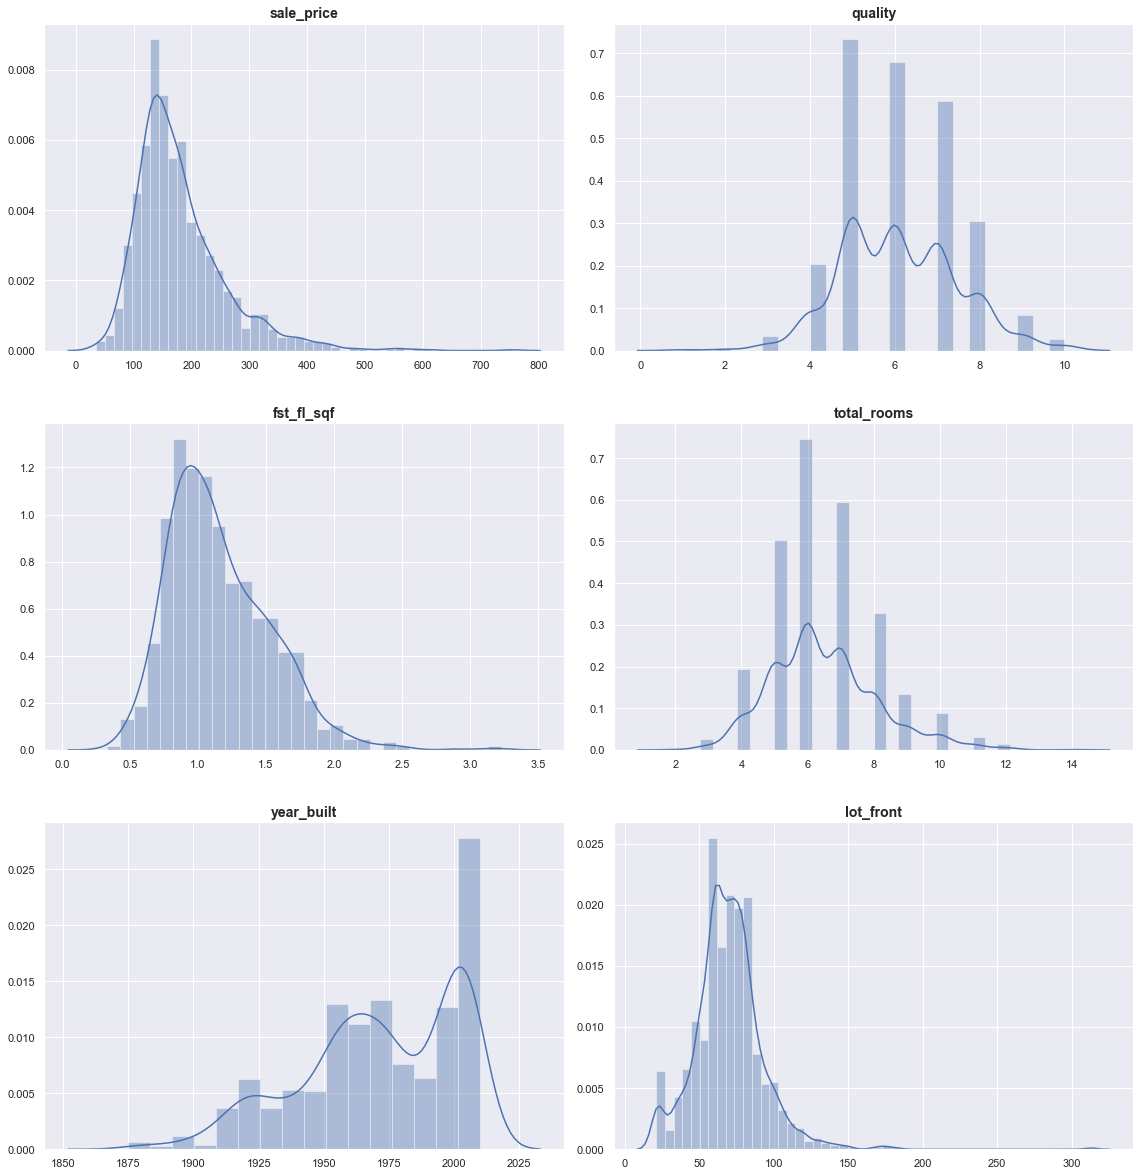

In [40]:
n = len(variables)
cols = 2
rows = n // cols

fig,ax = plt.subplots(rows, cols, figsize=(16,n*2.75))

i = 0
for name, values in variables.items():
    current_ax = ax[i//cols][i%cols]
    current_ax.set_title(name,  weight='bold').set_fontsize(14)
    sb.distplot(values[~np.isnan(values)],  ax=current_ax)
    i+=1

fig.tight_layout(h_pad=3)

### Correlación entre variables

In [27]:
independent_vars = [(name,values) for name,values in variables.items()][1:]

for name, values in independent_vars:
    not_nan = ~np.isnan(values)
    values = values[not_nan]
    print(name, np.corrcoef(values, sale_price[not_nan])[1][0]) #TODO make dataframe

quality 0.7939900504626412
fst_fl_sqf 0.6162887000998714
total_rooms 0.5647069399593065
year_built 0.5341706927117518
lot_front 0.36329161665389204


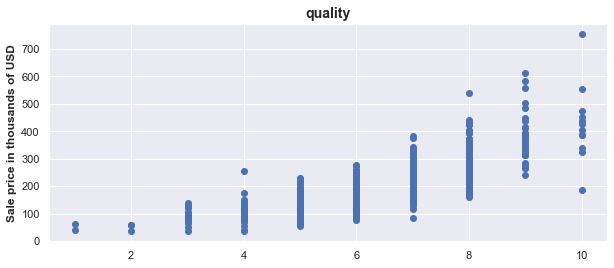

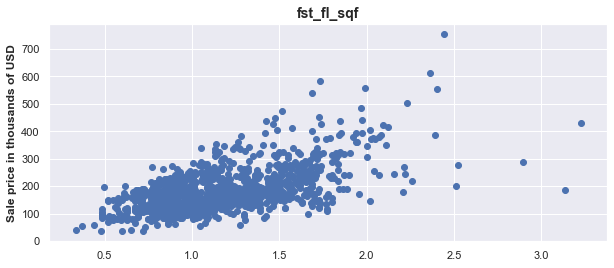

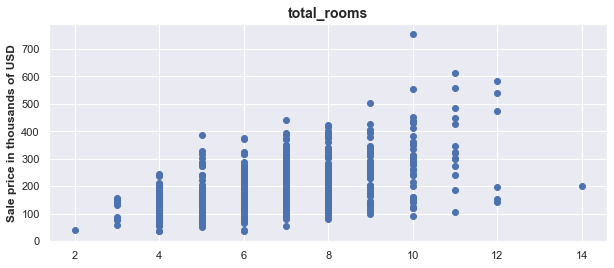

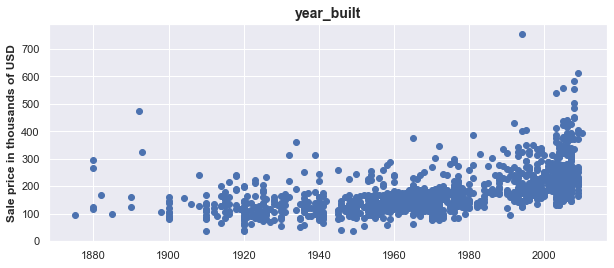

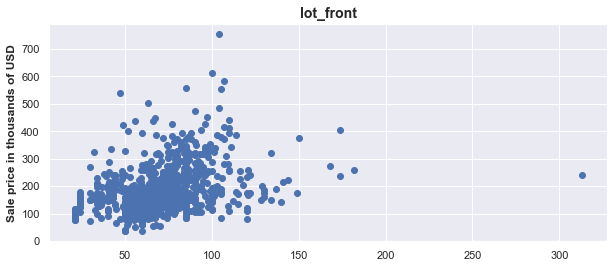

In [43]:
for name, values in independent_vars:
    plt.figure(figsize=(10,4))
    plt.scatter(x = values, y = sale_price)
    plt.ylabel("Sale price in thousands of USD", weight='bold')
    plt.gca().set_title(name,  weight='bold').set_fontsize(14) #TODO include r from dataframe above

#### Selección de variables
De las gráficas y coeficientes de correlación de arriba, notamos que quality (r=0.79399) y fst_fl_sqf (r=0.61628) son las dos variables independientes con mayor correlación con el precio de venta.

# Entrenamiento de modelo

In [ ]:
def train(x, y, epochs, print_error_every_n_epochs, learning_rate):
    pass